# Dueling DQN - Corridor Environment Experiment
* 논문 보는 곳 : https://arxiv.org/abs/1511.06581
* Dueling architecture의 policy evaluation 퍼포먼스를 실험한 결과인 <code>Figure 3</code>를 실습해봅시다.
  
  
* 논문에서 진행한 실험 세팅과 같지 않는 점  
    1. epsilon 값이 **0.01**입니다. 0.001로 설정하면 액션을 골고루 시행할 수 있는 기회가 적어 일부 Q(s, a)의 학습(update)이 이루어지지 않습니다.
    2. <code>Figure 3</code>의 y값이 **mean squared error**입니다. 저자들이 정확히 어떻게 실험을 했는지 알 수 없지만, Q(s, a)를 아무리 학습시켜도 squared error가 <code>10^0</code>에 수렴하지는 않았습니다.
    3. 종료 상태를 제외한 상태에선 **-1**의 보상을 받습니다. 즉, 최단경로로 이동하는 것을 목표로 합니다.

## 1. MDP Planning by Dynamic Programming
* Policy에 대한 exact Q(s, a), 즉 Q*(s, a)를 구하기 위해 다이나믹 프로그래밍으로 MDP를 풉니다.

In [20]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # 라이브러리들끼리 충돌을 일으켜서 matplotlib plot할 때 커널이 죽는 것을 방지

## 2. 하이퍼파라미터 세팅

In [21]:
learning_rate = 0.0001
epsilon = 0.01

In [22]:
exact_q_table = np.zeros((19, 50, 5)) # 각 상태에서 취할 수 있는 액션이 5개입니다.

In [23]:
def is_state(x, y):
    if y == 0 and (9 <= x <= 18):
        return True
    elif x == 9 and (0 <= y <= 49):
        return True
    elif y == 49 and (0 <= x <= 9):
        return True
    else:
        return False
    
def is_terminal(x, y):
    if x == 18 and y == 0:
        return True
    elif x == 0 and y == 49:
        return True
    else:
        return False

In [24]:
# 0 : 오른쪽, 1 : 왼쪽, 2 : 아래, 3 : 위, 4 : no-op
dx = [0, 0, 1, -1, 0]
dy = [1, -1, 0, 0, 0]

for repeat in range(0, 10000):
    for x in range(0, 19):
        for y in range(0, 50):
            if is_terminal(x, y) == True:
                continue
            if is_state(x, y) == True:
                for a in [0, 1, 2, 3, 4]:
                    reward = -1
                    if x == 18 and y == 0 and a == 2:
                        reward = 10
                    elif x == 1 and y == 49 and a == 3:
                        reward = 100

                    next_state_value = 0
                    next_x = x + dx[a]
                    next_y = y + dy[a]
                    
                    # 갈 수 없다면 제자리로 돌아오게 된다.
                    if is_state(next_x, next_y) == False:
                        next_x, next_y = x, y
                    
                    greedy_action = np.argmax(exact_q_table[next_x, next_y, :])
            
                    for a_ in [0, 1, 2, 3, 4]:
                        probability = 1 - epsilon + (epsilon/5) if a_ == greedy_action else epsilon/5
                        next_state_value += (probability*exact_q_table[next_x, next_y, a_])

                    exact_q_table[x, y, a] = reward + next_state_value

## 2. Policy Evaluation by Plain/Dueling Architecture
* epsilon-greedy 행동 정책에 대한 policy evaluaion을 수행합니다.

### 2.1 Corridor Environment : 논문과 동일합니다.

In [32]:
class Corridor():
    def __init__(self):
        self.x = 17
        self.y = 0
    
    def step(self, a):
        if a==0:
            self.move_right()
        elif a==1:
            self.move_left()
        elif a==2:
            self.move_down()
        elif a==3:
            self.move_up()
        elif a==4:
            self.no_op()

        reward = -1
        if self.x == 18 and self.y == 0:
            reward = 10
        elif self.x == 0 and self.y == 49:
            reward = 100
            
        done = self.is_done()
        return self.x, self.y, reward, done

    def move_right(self):
        self.y += 1  
        if is_state(self.x, self.y) == False:
            self.y -= 1
      
    def move_left(self):
        self.y -= 1
        if is_state(self.x, self.y) == False:
            self.y += 1
      
    def move_up(self):
        self.x -= 1
        if is_state(self.x, self.y) == False:
            self.x += 1
  
    def move_down(self):
        self.x += 1
        if is_state(self.x, self.y) == False:
            self.x -= 1
            
    def no_op(self):
        pass

    def is_done(self):
        if self.x == 18 and self.y == 0:
            return True
        elif self.x == 0 and self.y == 49:
            return True
        else:
            return False
      
    def reset(self):
        self.x = 17
        self.y = 0
        return (self.x, self.y)

### 2.2 Plain Q-network Architecture

In [33]:
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, state):
        out = self.forward(state)
        coin = random.random()
        
        if coin < epsilon:
            return random.randint(0,4)
        else:
            # 논문에 적혀있는 것과 마찬가지로, Optimal Q*(s, a)에서 argmax를 취합니다.
            state = list(state.cpu().detach())
            state = [int(val) for val in state]
            x, y = state
            return np.argmax(exact_q_table[x, y, :])


### 2.3 <code>Figure 3</code> Graphing

In [34]:
def graph_Figure3(x_list, y_list):
    set_matplotlib_formats('svg')
    
    plt.rcParams['figure.dpi'] = 120
    plt.rcParams['savefig.dpi'] = 120

    plt.xlabel('Episodes', fontsize=12)
    plt.ylabel('MSE', fontsize=12)

    plt.xscale('log')
    plt.yscale('log')
    
    plt.plot(x_list, y_list, linewidth=1.5)
    plt.xticks([10**i for i in range(3, 5)])
    plt.yticks([10**i for i in range(0, 4)])

    plt.savefig('figure3.png', bbox_inches='tight')

### 2.4 Main

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


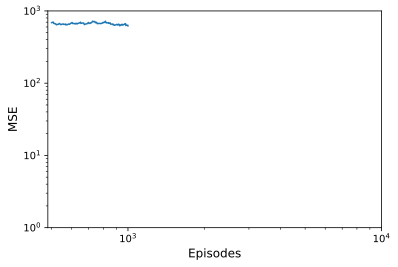

In [39]:
def main():
    x_list = []
    y_list = []
    
    env = Corridor()
    q = Qnet()
    score = 0.0  
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)
    
    for n_epi in range(1, 1001):
        print(n_epi)
        x, y = env.reset()
        done = False
        reward = 0
        
        while not done:
            state = torch.tensor([x, y], dtype=torch.float)
            a = q.sample_action(state)
            nxt_x, nxt_y, r, done = env.step(a)
            nxt_state = torch.tensor([nxt_x, nxt_y], dtype=torch.float)
            done_mask = 0.0 if done else 1.0
            
            q_out = q(state)
            q_a = q_out.gather(0, torch.tensor(a))
            
            q_prime_out = q(nxt_state)
            next_greedy_action = np.argmax(exact_q_table[nxt_x, nxt_y, :])
            
            mean_q_prime = 0
            for a_ in [0, 1, 2, 3, 4]:
                probability = 1 - epsilon + (epsilon/5) if a_ == next_greedy_action else epsilon/5
                mean_q_prime += (probability*q_prime_out.gather(0, torch.tensor(a_)))
            
            target = r + mean_q_prime*done_mask
            
            loss = F.mse_loss(q_a, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            x, y = nxt_x, nxt_y

            score += r
            reward += r
            if done:
                break
                
        se = 0
        if n_epi >= 500:
            for row in range(0, 19):
                for col in range(0, 50):
                    if is_state(row, col) == True and is_terminal(row, col) == False:
                        state = torch.tensor([row, col], dtype=torch.float)
                        se += np.sum((q(state).cpu().detach().numpy() - exact_q_table[row, col, :])**2)
            x_list += [n_epi]
            y_list += [se/(68*5)] # mse
        
    graph_Figure3(x_list, y_list)
            

            
if __name__ == '__main__':
    main()